In [35]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions
from src.processing.recent_fires import gedi_matching, matching_analysis
from src.visualization.gedi_viz import geo_plot

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_matching)
importlib.reload(matching_analysis)
from src.data.gedi_pipeline import get_severity

2023-06-07 16:04:08,785 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [4]:
gedi_gdf= gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')
gedi_burned, gedi_unburned = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_gdf)

2023-06-07 11:25:34,802 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-07 11:25:35,138 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-07 11:25:36,439 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-07 11:25:36,760 DEBUG: Number of shots that burned exactly once:                    1253729 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-07 11:25:36,914 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    771977 [in exclude_shots_on_burn_b

In [5]:
gedi_l2b = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/gedi_l2b_sierras_matched_lc_all_2x2.csv')
gedi_burned_l2b, gedi_unburned_l2b = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_l2b)

2023-06-07 11:28:21,867 DEBUG: Excluded shots on the burn boundaries, shots remaining:         14968077 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-07 11:28:22,431 DEBUG: Number of GEDI shots that burned at least once:                  2184975 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-07 11:28:24,970 DEBUG: Number of GEDI shots that never burned since 1984:         12539296 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-07 11:28:25,834 DEBUG: Number of shots that burned exactly once:                    1891695 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-07 11:28:26,169 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    1192212 [in exclude_shots_on_bur

### Analysis of GEI measurements in unburned regions - (2019, 2020) VS. (2021, 2022)

We expect very small changes to AGBD (and possibly PAI) measurements from matching shots. We should use it to callibrate our burned regions.

In [13]:
matches = gedi_matching.match_measurements_before_and_after_date("01-01-2021", gedi_unburned, 'agbd')

In [15]:
matches_l2b = gedi_matching.match_measurements_before_and_after_date("01-01-2021", gedi_unburned_l2b, 'pai')

In [19]:
matches_paiz = gedi_matching.match_pai_z_before_and_after_date("01-01-2021", gedi_unburned_l2b)

In [21]:
matches

,shot_number,absolute_time,lon_lowestmode,lat_lowestmode,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,l2_quality_flag,l4_quality_flag,...,gedi_year,gedi_month,time_since_burn,closest_distance,match_datetime,agbd_after,agbd_diff,agbd_rel,start_offset,end_offset
166,55000500300288931,2019-12-02 05:16:17.198817+00:00,-117.996731,37.039413,105.945633,54.687820,173.998734,3.038114,1,1,...,2019,12,-1,317.005824,2022-03-19 02:41:53.165506+00:00,49.129292,56.816341,0.463722,0,None
170,55000500300288938,2019-12-02 05:16:17.256665+00:00,-117.993338,37.037050,1561.406982,1276.337524,1875.186279,5.193314,1,1,...,2019,12,-1,82.154860,2022-03-19 02:41:53.215090+00:00,42.480953,1518.926029,0.027207,0,None
171,55000500300288940,2019-12-02 05:16:17.273193+00:00,-117.992372,37.036376,1064.148804,848.705750,1303.934448,4.403353,1,1,...,2019,12,-1,31.126753,2022-03-19 02:41:53.223354+00:00,41.270653,1022.878151,0.038783,0,None
173,55000500300288942,2019-12-02 05:16:17.289721+00:00,-117.991400,37.035700,1006.959839,799.724670,1238.044678,4.314166,1,1,...,2019,12,-1,52.330860,2022-03-19 02:41:53.239882+00:00,33.051270,973.908569,0.032823,0,None
175,55000500300288944,2019-12-02 05:16:17.306249+00:00,-117.990431,37.035025,2585.989502,2161.758301,3048.203369,6.870738,1,1,...,2019,12,-1,120.461984,2022-03-19 02:41:53.256410+00:00,28.863516,2557.125986,0.011161,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27629475,47980800300404111,2019-10-17 23:05:35.143115+00:00,-119.274053,38.764350,0.870713,-9999.000000,14.567701,3.008365,1,1,...,2019,10,-1,313.183836,2022-11-06 07:03:37.911221+00:00,0.870713,0.000000,1.000000,0,None
27629476,47980800300404112,2019-10-17 23:05:35.151379+00:00,-119.273545,38.764026,0.919862,-9999.000000,14.765323,3.008004,1,1,...,2019,10,-1,280.028675,2022-11-06 07:03:37.911221+00:00,0.870713,0.049149,0.946569,0,None
27629483,32830600200465930,2019-07-12 07:19:50.933985+00:00,-120.460050,40.769266,2.540479,-9999.000000,20.012182,2.999950,1,1,...,2019,7,-1,37.869698,2021-07-09 13:28:27.589582+00:00,4.210344,-1.669864,1.657303,0,None
27629484,32830600200465932,2019-07-12 07:19:50.950513+00:00,-120.458971,40.769886,5.482157,-9999.000000,27.220886,2.992357,1,1,...,2019,7,-1,112.831691,2021-07-09 13:28:27.589582+00:00,4.210344,1.271813,0.768009,0,None


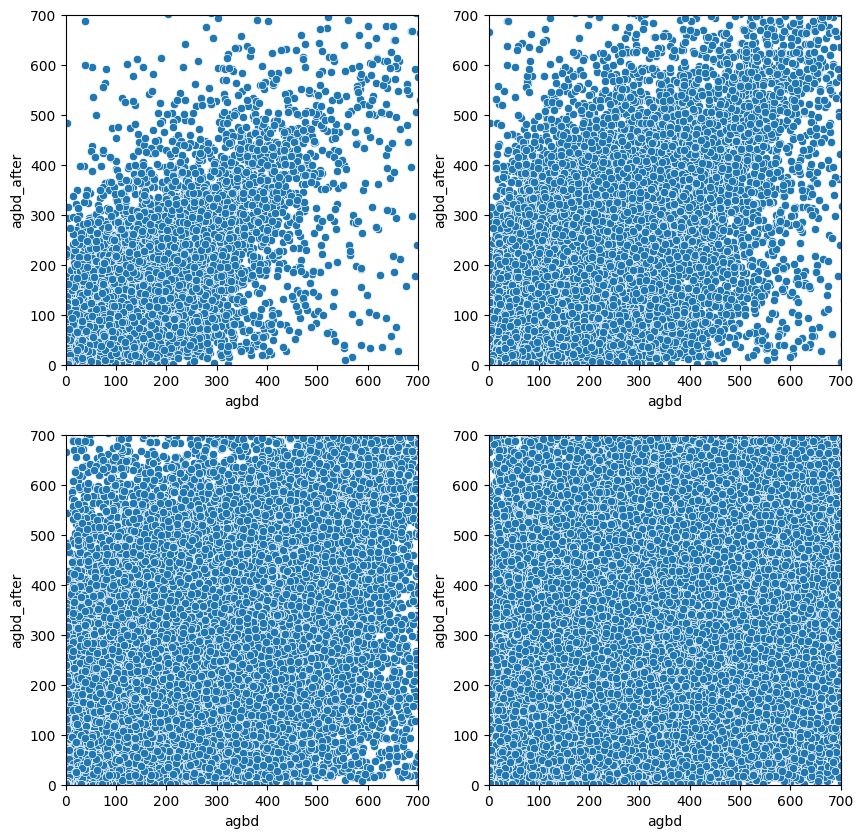

In [23]:
matching_analysis.plot_for_distance(matches, 'agbd')

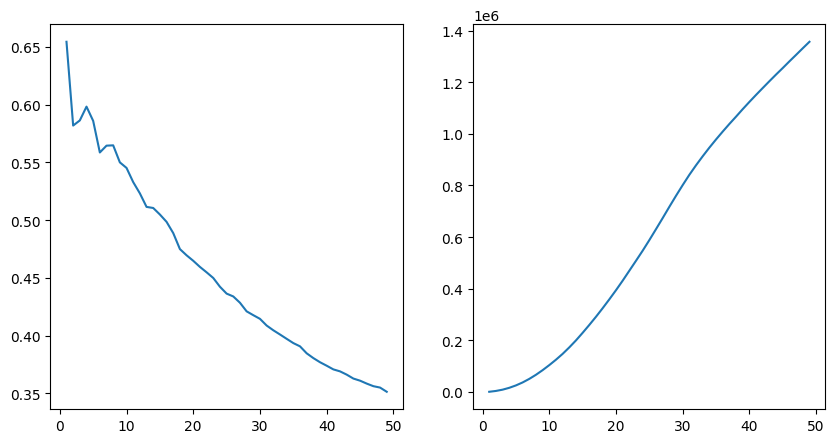

In [29]:
matching_analysis.plot_control_error_for_distances(matches, 'agbd')

In [30]:
def filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1) & (df.pft_class == 1)]

In [31]:
close_matches = filter_land_cover(matches[matches.closest_distance < 10])

Best Linear regression coefficient is [0.71529154].         R squared is : 0.506656701159973.
The error for coeff = 1 is: 0.4191369250457341.


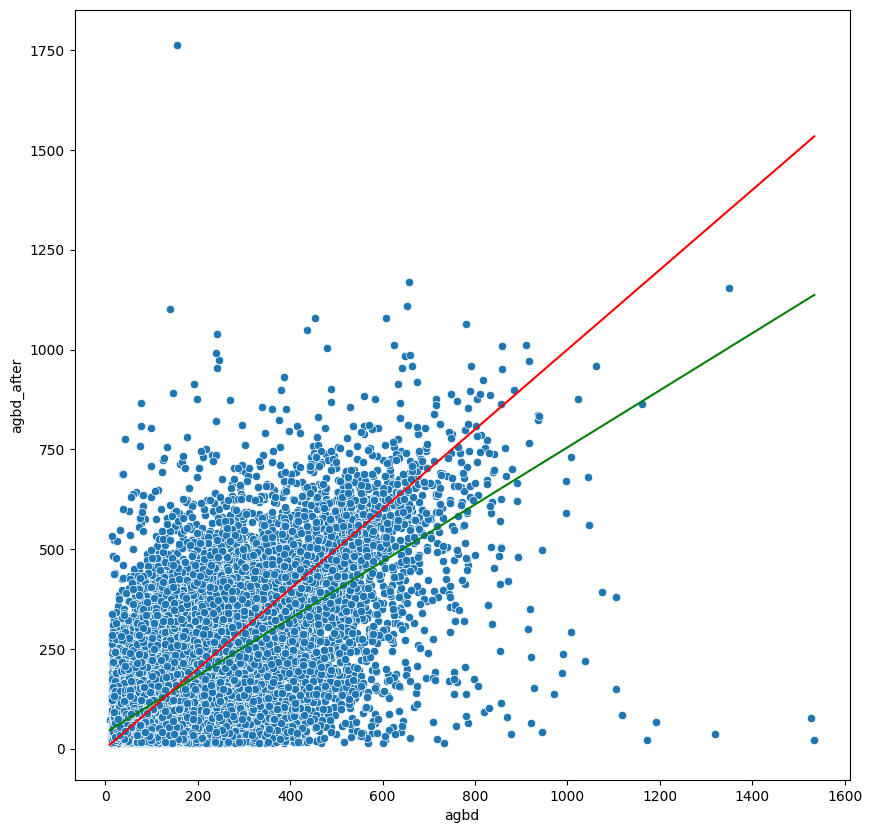

In [32]:
matching_analysis.fit_linear_regression(close_matches, 'agbd')

Best Linear regression coefficient is [0.66275637].         R squared is : 0.4392860653378461.
The error for coeff = 1 is: 0.32418121705955505.


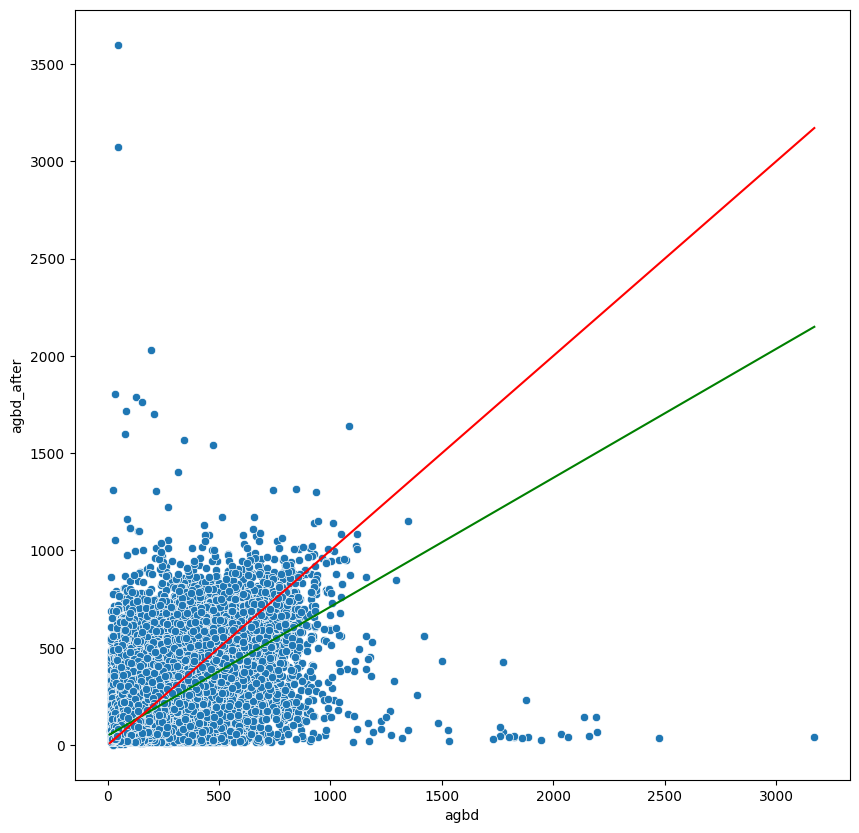

In [33]:
matching_analysis.fit_linear_regression(filter_land_cover(matches[matches.closest_distance < 20]), 'agbd')

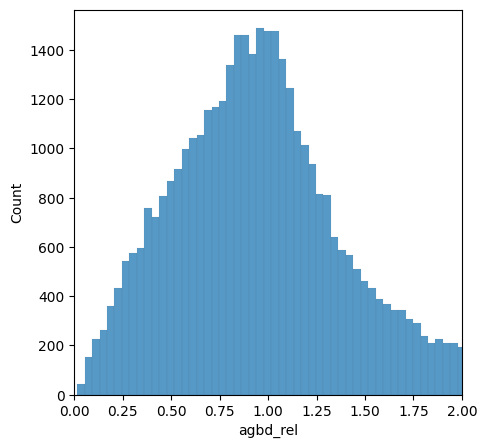

In [36]:
matching_analysis.plot_rel_difference(close_matches, 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


         sumsquare_error          aic            bic  kl_div  ks_statistic  \
beta            0.000027  9529.198196 -891377.706347     inf      0.097669   
norm            0.000027  9138.091934 -891298.206167     inf      0.099839   
gamma           0.000029          inf -887631.844921     inf      0.113148   
lognorm         0.000153  2055.275559 -817630.254549     inf      0.814417   
burr            0.000158  2008.227151 -816293.344534     inf      0.691686   

         ks_pvalue  
beta           0.0  
norm           0.0  
gamma          0.0  
lognorm        0.0  
burr           0.0  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 25.97it/s]


{'norm': {'loc': 5.303924548467302, 'scale': 100.71209772471147}}


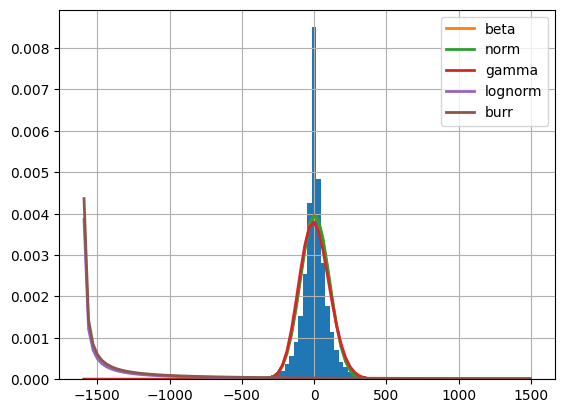

In [37]:
matching_analysis.fit_distributions(close_matches, 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:01<00:00,  4.37it/s]


         sumsquare_error           aic            bic  kl_div  ks_statistic  \
burr            0.021055   1940.432143 -610451.836203     inf      0.028174   
lognorm         0.065267   2781.483082 -562855.219084     inf      0.054207   
norm            0.411343  33562.965886 -485399.112560     inf      0.188172   
beta            0.570113   2845.162986 -471642.603879     inf      0.191291   
gamma           0.893388   1065.838052 -452751.459917     inf      0.287843   

             ks_pvalue  
burr      1.882708e-29  
lognorm  6.531335e-108  
norm      0.000000e+00  
beta      0.000000e+00  
gamma     0.000000e+00  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 25.80it/s]


{'norm': {'loc': 1.1802601949144957, 'scale': 1.0461705457049604}}


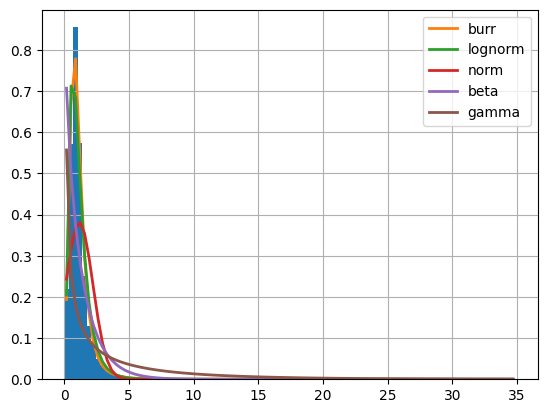

In [38]:
matching_analysis.fit_distributions(close_matches, 'agbd', rel=True)